# tutorial

In this tutorial, we will demonstrate
1. how to enumerate all **stabilizer states**
2. how to compute the   **stabilizer fidelity**
3. how to compute the   **stabilizer extent**

## 1.stabilizer states

Let $\mathcal{S}_n = \{ | \phi_j \rangle \}_j$ be the set of $n$-qubit stabilizer states and $\mathbb{F}_2$ be the finite field with two elements.

For all $k \in \{1,\dots,n\}$, we define
$$
\begin{align*}
\mathcal{Q}_k &:= \left\{ Q | Q \in \mathbb{F}_2^{k \times k} \textrm{ is an upper triangular matrix} \right\},\\
\mathcal{R}_k &:= \left\{ R | R \in \mathbb{F}_2^{n \times k} \textrm{ is a reduced column echelon form matrix with $\mathrm{Rank}R=k$} \right\},\\
\mathcal{T}_R &:= \left\{ \mathrlap{\:t}\phantom{Q} | \mathrlap{\:t}\phantom{Q} \in \mathbb{F}_2^{n \vphantom{\times k}} \textrm{ is a representative of element in the quotient space $\mathbb{F}_2^n / \mathrm{Im}(R)$} \right\}.
\end{align*}
$$

We also define the set of states $\mathcal{S}_{n,k}$ as
$$
\begin{equation}
\mathcal{S}_{n,k} :=
\left\{ \frac{1}{2^{k/2}} \sum_{x=0}^{2^k-1}(-1)^{x^\top Q x} i^{c^\top x}\ket{R x+t} \;\middle|\; Q \in \mathcal{Q}_k, c \in \mathbb{F}_2^k, R \in \mathcal{R}_k, t\in \mathcal{T}_R \right\},
\end{equation}
$$
and define $\mathcal{S}_{n,0} := \left\{ \ket{t} | t \in \mathbb{F}_2^{n} \right\}$.

Then, we have
$$
\bigcup_{k=0}^{n} \mathcal{S}_{n,k} = \mathcal{S}_n.
$$

This result is a variant of the fact on https://arxiv.org/abs/2008.05234.

Here, we compute the $A$ matrix, defined by $(A_n)_{i,j}=\langle i | \phi_j \rangle$.

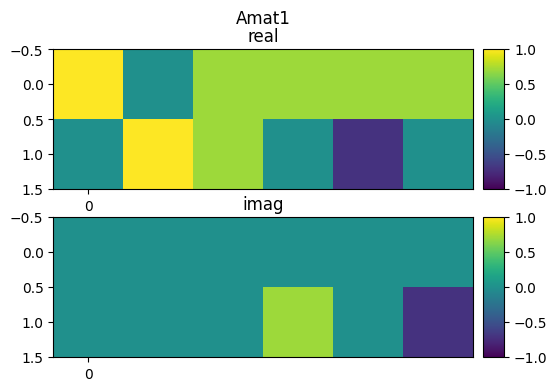

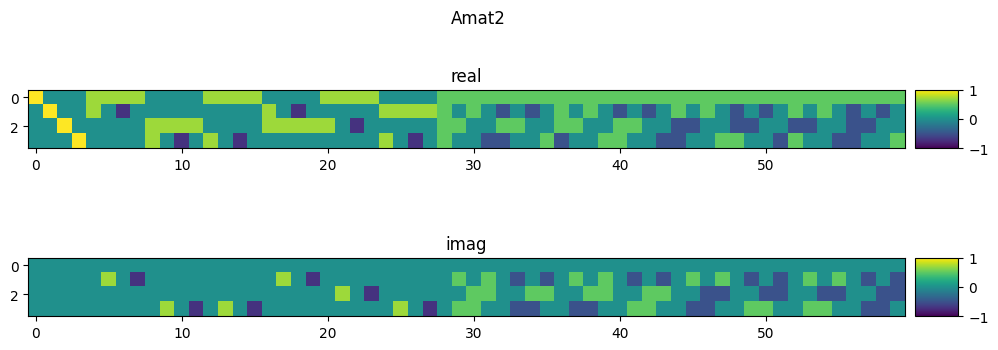

In [1]:
import numpy as np
from exputils.math.popcount import popcount
from exputils.Amat.make import enumerate_RREF
from exputils.vis_matrix import vis_matrix


def _make_Amat_sub(
    n: int, k: int, R: int, t: int, phases: np.ndarray, coeff: float
) -> np.ndarray:
    # given n,k,R,t, (-1^{x^T Q x} i^{cx}) for all Q,c as phases, and 1/2^{k/2} as coeff
    # compute 1/2^{k/2} \sum_{x=0}^{2^k-1} (-1^{x^T Q x} i^{cx}) |Rx+t> for all Q,c
    rows = np.zeros((1 << n, 1 << (k * (k + 1) // 2) + k), dtype=np.complex128)
    for x in range(1 << k):
        # t
        row_idx = t
        # Rx+t
        for idx in range(k):
            if x & (1 << idx):
                # addition on F_2^n is xor operation
                row_idx ^= R[idx]
        # (-1^{x^T Q x} i^{cx}) |Rx+t>
        rows[row_idx] = phases[x]
    return rows * coeff


def make_Amat(n: int) -> np.ndarray:
    ans = []
    for k in range(n + 1):
        if k == 0:
            rows = np.zeros((1 << n, 1 << n), dtype=np.complex128)
            for t in range(1 << n):
                rows[t][t] = 1.0
            ans.append(rows)
        else:
            # Q_{i,j} could be non-zero only if i<=j since it is an upper triangular matrix
            Q_idxs = [-1 for _ in range(k * k)]
            Q_idx = 0
            for i in range(k):
                for j in range(i, k):
                    Q_idxs[i * k + j] = Q_idx
                    Q_idx += 1

            # compute (-1)^{x^T Q x} i^{cx} for all Q,c
            phases = np.ones((1 << k, 1 << (k * (k + 1) // 2 + k)), dtype=np.complex128)
            complexes = np.ones((1 << k, 1 << k), dtype=np.complex128)
            for c in range(1 << k):
                for x in range(1 << k):
                    complexes[c][x] *= 1j ** popcount(c & x)
            phase_idx = 0
            for Q in range(1 << (k * (k + 1) // 2)):
                for x in range(1 << k):
                    for i in range(k):
                        for j in range(i, k):
                            if (
                                (x & (1 << i))
                                and (x & (1 << j))
                                and (Q & (1 << Q_idxs[i * k + j]))
                            ):
                                phases[x][phase_idx] *= -1
                for c in range(1 << k):
                    phases[:, phase_idx + c] = phases[:, phase_idx] * complexes[c]
                phase_idx += 1 << k

            # With the above computation, we can compute the Amat
            # For t, please refer to https://stackoverflow.com/questions/7277554/what-is-a-good-way-to-iterate-a-number-through-all-the-possible-values-of-a-mask#comment9091440_7277818
            coeff = 1 / np.sqrt(1 << k)
            for R, t_mask in enumerate_RREF(n, k):
                # print("0" * (n - len(bin(t_mask)[2:])) + bin(t_mask)[2:])
                t = 0
                while True:
                    ans.append(_make_Amat_sub(n, k, R, t, phases, coeff))
                    t = (t + ~t_mask + 1) & t_mask
                    if t == 0:
                        break
    return np.block(ans)


if __name__ == "__main__":
    Amat1 = make_Amat(1)
    Amat2 = make_Amat(2)
    vis_matrix(Amat1, "Amat1")
    vis_matrix(Amat2, "Amat2")

## 2.stabilizer fidelity

The stabilizer fidelity is defined as
$$
\sqrt{F(\psi)} = \max_{\phi \in \mathcal{S}_n} |\langle \phi | \psi \rangle|.
$$

Here, we provide the Python code to compute it recursively.
The more efficient way, stabilizer pruning, is also available in the C++ code in this repository.

In [2]:
from typing import List
from exputils.stabilizer_group import total_stabilizer_group_size
from exputils.state.random_ket import make_random_quantum_state


def calc_dot_sub(k: int, psi: List[complex]) -> List[complex]:
    assert 1 <= k
    assert len(psi) == (1 << k)
    if k == 1:
        return [
            psi[0] + psi[1],
            psi[0] - psi[1],
            psi[0] + 1j * psi[1],
            psi[0] - 1j * psi[1],
        ]
    else:
        ret = []

        def bfs(next: List[complex], c_0: int, q_00: int, q_1: int, i: int):
            assert 1 <= i < k
            assert c_0 == 0 or c_0 == 1
            assert q_00 == 0 or q_00 == 1
            coeff = 1j**c_0
            for q_0i in [0, 1]:
                for x1 in range(1 << (i - 1), 1 << i):
                    if q_00 ^ (popcount(q_1 & x1) & 1):
                        next[x1] = psi[(x1 << 1) + 0] - coeff * psi[(x1 << 1) + 1]
                    else:
                        next[x1] = psi[(x1 << 1) + 0] + coeff * psi[(x1 << 1) + 1]
                if i < k - 1:
                    bfs(next, c_0, q_00, q_1 ^ (q_0i << (i - 1)), i + 1)
                else:
                    ret.extend(calc_dot_sub(k - 1, next))
                coeff *= -1

        next = [0] * (1 << (k - 1))
        for c_0 in [0, 1]:
            for q_00 in [0, 1]:
                next[0] = psi[0] + ((-1) ** q_00) * (1j**c_0) * psi[1]
                bfs(next, c_0, q_00, 0, 1)

        return ret


def calc_dot(n: int, psi: List[complex]) -> List[complex]:
    assert len(psi) == (1 << n)
    assert type(psi) == list
    ret = np.zeros(total_stabilizer_group_size(n), dtype=np.complex128)
    psi = [complex(x).conjugate() for x in psi]
    ret[: len(psi)] = psi[:]  # k=0
    ret_idx = len(psi)
    for k in range(1, n + 1):
        sqrt2k = np.sqrt(2) ** k
        for mat, t_mask in enumerate_RREF(n, k):
            t = 0
            while True:
                psi2 = [0] * (1 << k)
                for x in range(1 << k):
                    row_idx = t
                    for idx in range(k):
                        if x & (1 << idx):
                            row_idx ^= mat[idx]
                    psi2[x] = psi[row_idx]

                # Now, we fixed k,R,t
                # In the function calc_dot_sub, we consider all Q,c
                res = calc_dot_sub(k, np.array(psi2, dtype=np.complex128))

                ret[ret_idx : ret_idx + len(res)] = res / sqrt2k
                ret_idx += len(res)
                t = (t + ~t_mask + 1) & t_mask
                if t == 0:
                    break
    assert ret_idx == len(ret), f"{idx=} {len(ret)=}"
    return ret


if __name__ == "__main__":
    Amat2 = make_Amat(2)
    psi2 = make_random_quantum_state("pure", 2, seed=0)
    print("Naive calculation:")
    print(f"  {np.max(np.abs(Amat2.T @ psi2))=}")
    dot2 = calc_dot(2, psi2.tolist())
    print("Our calculation:")
    print(f"  {np.max(np.abs(dot2))=}")

Naive calculation:
  np.max(np.abs(Amat2.T @ psi2))=0.8768192835592745
Our calculation:
  np.max(np.abs(dot2))=0.8768192835592744


If you compiled the C++ code successfully, you can run the following code to compute the stabilizer fidelity.

The figure below shows all the overlaps (inner products) between all the stabilizer states and the target state.

Please note that the naive method only works for small $n \leq 5$.
For $n>5$, you cannot rely on the naive method due to the super-exponential growth of the number of stabilizer states.

[k|progress|range]: 1 | 2.01600e+03/2.42352e+06 | [0.01551, 0.39928] | 5[ms]
[k|progress|range]: 2 | 4.16960e+04/2.42352e+06 | [0.38773, 0.49106] | 7[ms]
[k|progress|range]: 3 | 3.59136e+05/2.42352e+06 | [0.46169, 0.57949] | 10[ms]
[k|progress|range]: 4 | 1.37494e+06/2.42352e+06 | [0.50294, 0.59642] | 12[ms]
[k|progress|range]: 5 | 2.42352e+06/2.42352e+06 | [0.51430, 0.59912] | 14[ms]
 calculation time : 14[ms]
Naive: 0.089 sec
Fast(Python): 7.231 sec
Fast(C++): 0.173 sec


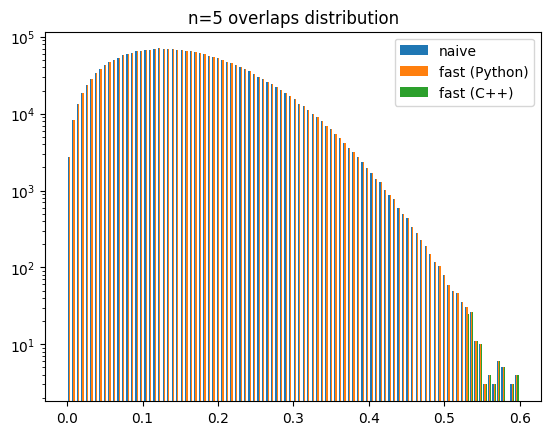

In [3]:
import time
import random
import matplotlib.pyplot as plt

from exputils.Amat.get import get_Amat
from exputils.dot.calc_dot import calc_dot
from exputils.dot.get_topK_Amat import get_topK_Amat
from exputils.state.random_ket import make_random_quantum_state

n = 5
random.seed(0)
psi = make_random_quantum_state("pure", n, seed=0)

Amat = get_Amat(n)

t0 = time.perf_counter()
ansSlow = np.array(psi).conj() @ Amat
t1 = time.perf_counter()
ansFast = calc_dot(n, psi.tolist())
t2 = time.perf_counter()
try:
    states = get_topK_Amat(n, psi, K=100, is_dual_mode=False, verbose=True)
    ansFast2 = np.abs(psi.conjugate() @ states)
except Exception as e:
    print(f"Error: {e}")
    print("Please make sure you read README.md and compile C++ code.")
    ansFast2 = np.zeros(1)
t3 = time.perf_counter()

print(f"Naive: {t1-t0:.3f} sec")  # Fast because it pre-compute the Amat
print(f"Fast(Python): {t2-t1:.3f} sec")
print(f"Fast(C++): {t3-t2:.3f} sec")  # Inner product computation itself is very fast.

if ansFast2.size > 1:
    plt.hist([np.abs(ansSlow), np.abs(ansFast), np.abs(ansFast2)], bins=100)
    plt.legend(["naive", "fast (Python)", "fast (C++)"])
else:
    plt.hist([np.abs(ansSlow), np.abs(ansFast)], bins=100)
    plt.legend(["naive", "fast (Python)"])
plt.title(f"n={n} overlaps distribution")
plt.yscale("log")
plt.show()

## 3.stabilizer extent

The stabilizer extent is defined as
$$
\begin{equation*}
  \xi(\psi) := \min_{c\in \mathbb{C}^{|\mathcal{S}_n|}}
  \left\{ \|c\|_1^2 \;\middle|\; \ket{\psi} = \sum_{j=1}^{|\mathcal{S}_n|} c_j \ket{\phi_j} \right\}.
\end{equation*}
$$
This definition can be simplified as the complex $L^1$-norm minimization problem as follows:
$$
\begin{equation*}
  \sqrt{\xi(\psi)} = \min_{x \in \mathbb{C}^{|\mathcal{S}_n|}}
  \left\{ \|x\|_1 | A_n x = b \right\},
\end{equation*}
$$
where $A_n \in \mathbb{C}^{2^n \times |\mathcal{S}_n|}$ is defined as $(A_n)_{i,j} := \langle i | \phi_j \rangle$ and $b \in \mathbb{C}^{2^n}$ as $b_i := \langle i | \psi \rangle$ using the computational basis $\{\ket{i}\}_{i=0}^{2^n-1}$.

This can be computed with the CG method with SOCP solver.

You can use cvxpy without any additional installation, but we highly recommend installing MOSEK for faster computation.
Please refer README.md for the installation.

In [4]:
import numpy as np
import scipy.sparse
from exputils.extent.custom import calculate_extent_custom
from exputils.dot.get_topK_Amat import get_topK_Amat


def calculate_extent_CG(
    n: int, psi: np.ndarray, method: str = "mosek", verbose=False
) -> tuple:
    # Even if verbose=False, print some log.
    print(f"CG: {n=}, {method=}")
    print("start: calculate dots")
    if n <= 8:
        K = 10000
    else:
        K = 100000
    current_Amat = get_topK_Amat(n, psi, False, K, True)
    iter_max = 30
    eps = 1e-8
    discard_current_threshold = 0.8
    extends = []
    max_values = []
    for it in range(iter_max):
        print(f"iteration: {it + 1} / {iter_max}, Amat.shape = {current_Amat.shape}")
        print("start: solve SOCP")
        stabilizer_extent, coeff, dual = calculate_extent_custom(
            n, current_Amat, psi, method, verbose=verbose
        )
        extends.append(stabilizer_extent)
        print(f"{stabilizer_extent=}")
        print("start: calculate dual dots")
        extra_Amat = get_topK_Amat(n, dual, True, K, True)
        if extra_Amat.shape[1] == 0:
            print("OPTIMAL!")
            max_values.append(1.0)
            break
        assert np.all(np.count_nonzero(extra_Amat.toarray(), axis=0) > 0)

        dual_dots = np.abs(dual.conj().T @ extra_Amat)
        violated_count = np.sum(dual_dots > 1 + eps)
        max_values.append(max(1.0, np.max(dual_dots) if len(dual_dots) > 0 else 0))
        print(f"# of violations(LB): {violated_count}")
        if violated_count == 0:
            # this could happen if 1 < max(dual_dots) < 1+eps
            print("OPTIMAL!")
            break

        # restrict current Amat
        nonbasic_indices = np.abs(coeff) > eps
        critical_indices = np.abs(dual @ current_Amat) >= discard_current_threshold
        remain_indices = np.logical_or(nonbasic_indices, critical_indices)
        current_Amat = scipy.sparse.hstack(
            [current_Amat[:, remain_indices], extra_Amat]
        )

    return stabilizer_extent, extends, max_values, dual


def test_calculate_extent_CG():
    from exputils.state.random_ket import make_random_quantum_state
    from exputils.extent.actual import calculate_extent_actual

    n = 3
    seed = 0
    np.random.seed(seed)
    psi = make_random_quantum_state("pure", n, seed)
    psi_check = psi.copy()

    # method="mosek" # you can also use "gurobi" instead, but is still slow
    method = "cvx"  # it takes a very long time with "cvx"

    # proposed method
    stabilizerExtent = calculate_extent_CG(n, psi, method)[0]
    print(f"{stabilizerExtent=}")

    # naive method
    stabilizerExtent_check = calculate_extent_actual(n, psi, method)[0]
    print(f"{stabilizerExtent_check=}")

    assert np.allclose(psi, psi_check, atol=1e-5)
    assert np.isclose(stabilizerExtent, stabilizerExtent_check, atol=1e-5)
    print("CORRECT!")


if __name__ == "__main__":
    test_calculate_extent_CG()

CG: n=3, method='cvx'
start: calculate dots
[k|progress|range]: 1 | 1.20000e+02/1.08000e+03 | [0.01721, 0.87813] | 1[ms]
[k|progress|range]: 2 | 5.68000e+02/1.08000e+03 | [0.01721, 0.87813] | 2[ms]
[k|progress|range]: 3 | 1.08000e+03/1.08000e+03 | [0.01721, 0.87813] | 2[ms]
 calculation time : 2[ms]
iteration: 1 / 30, Amat.shape = (8, 1080)
start: solve SOCP
stabilizer_extent=1.7618305423304728
start: calculate dual dots
[k|progress|range]: 1 | 1.20000e+02/1.08000e+03 | [1.00000, 1.00000] | 1[ms]
[k|progress|range]: 2 | 5.68000e+02/1.08000e+03 | [0.97280, 1.00000] | 2[ms]
[k|progress|range]: 3 | 1.08000e+03/1.08000e+03 | [0.97280, 1.00000] | 2[ms]
 calculation time : 3[ms]
# of violations(LB): 0
OPTIMAL!
stabilizerExtent=1.7618305423304728
stabilizerExtent_check=1.7618305423304745
CORRECT!
